In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from collections import Counter

# visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# NLP
import langdetect
import nltk
import readability
import spacy

# pip install --no-cache-dir https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-2.3.1/en_core_web_lg-2.3.1.tar.gz
# python -m spacy download en_core_web_lg
import en_core_web_lg

# ML
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
# Setup
# Spacy model
nlp = en_core_web_lg.load()

# NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')


[nltk_data] Downloading package punkt to /home/hvelichkov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/hvelichkov/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/hvelichkov/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

# Readability Assement
### Using regression models to calculate readability score

## Introduction

## What is readability score


Readability is the ease with which a reader can understand a written text. Numeric readability metrics (also known as readability tests or readability formulas) for natural language tend to use simple measures like word length (by letter or syllable), sentence length, and sometimes some measure of word frequency. There are also formulas which calculates the score.

## Reading the data

In this notebook I'm going to use data provided in [Kaggle Commotlit competition](https://www.kaggle.com/c/commonlitreadabilityprize/). 

Files:
 - data/commonlitreadability.csv
 
Colums:
 - id - unique ID for excerpt
 - url_legal - URL of source - this is blank in the test set.
 - license - license of source material - this is blank in the test set.
 - excerpt - text to predict reading ease of
 - target - reading ease. Higher value means easier to read the excerpt
 - standard_error - measure of spread of scores among multiple raters for each excerpt.
 
I'm going to use only excerpt and target columns. 


In [4]:
# reading the training set
readability_data = pd.read_csv("data/commonlitreadability.csv", index_col=0)

## Data exploration

In [5]:
readability_data.head()

,url_legal,license,excerpt,target,standard_error
id,,,,,
c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [6]:
readability_data.shape

(2834, 5)

In [7]:
readability_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2834 entries, c12129c31 to 5b990ba77
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   url_legal       830 non-null    object 
 1   license         830 non-null    object 
 2   excerpt         2834 non-null   object 
 3   target          2834 non-null   float64
 4   standard_error  2834 non-null   float64
dtypes: float64(2), object(3)
memory usage: 132.8+ KB


The type of the columns are correct. Most of the records in *url_legal* and *license* are NULL

In [8]:
def plot_distribution(var, title="", xlabel=""):
    """
        Compute and plot distribution of variable
        
        Params:
            - var - pandas.Series
            - title - string. histogram title
            - xlabel - string. x axis label
    """
    plt.hist(var, bins="fd")
    plt.axvline(var.mean(), c="red", label=f"mean: {np.round(var.mean(), 2)}")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.legend()
    plt.show()
    
def plot_scatter_grid(dataset, X_columns, target, rows, cols, title):
    """
        Plot grid of scatter plots
        Params:
            - dataset - pandas.Dataframe
            - X_columns - list of columns names
            - target - taget column name
            - rows - number of rows
            - cols - number of cols
            - title
    """
    fig = plt.figure(figsize=(20, 20))
    gs = fig.add_gridspec(nrows=rows, ncols=cols)

    y = dataset[target]
    
    for row in range(rows):
        for col in range(cols):
            index = row * cols + col
            if index >= len(X_columns):
                break
                
            x_col = X_columns[index]
            ax = fig.add_subplot(gs[row, col])
            ax.scatter(dataset[x_col], y)
            
            ax.set_xlabel(x_col)
            ax.set_ylabel(target)
            
    plt.suptitle(title, fontsize=20)

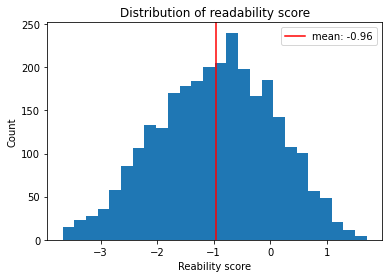

In [9]:
plot_distribution(readability_data.target, "Distribution of readability score", "Reability score")

*target* has normal distribution. Negative values are more than positive ones

In [10]:
readability_data.describe()

,target,standard_error
count,2834.000000,2834.000000
mean,-0.959319,0.491435
std,1.033579,0.034818
min,-3.676268,0.000000
25%,-1.690320,0.468543
50%,-0.912190,0.484721
75%,-0.202540,0.506268
max,1.711390,0.649671


The easiest excerpt has readability score 1.711390, the most difficult -3.676268

Let's examine some of the experts:

In [11]:
print(readability_data.loc[readability_data.target.idxmax(), "excerpt"])

When you think of dinosaurs and where they lived, what do you picture? Do you see hot, steamy swamps, thick jungles, or sunny plains? Dinosaurs lived in those places, yes. But did you know that some dinosaurs lived in the cold and the darkness near the North and South Poles?
This surprised scientists, too. Paleontologists used to believe that dinosaurs lived only in the warmest parts of the world. They thought that dinosaurs could only have lived in places where turtles, crocodiles, and snakes live today. Later, these dinosaur scientists began finding bones in surprising places.
One of those surprising fossil beds is a place called Dinosaur Cove, Australia. One hundred million years ago, Australia was connected to Antarctica. Both continents were located near the South Pole. Today, paleontologists dig dinosaur fossils out of the ground. They think about what those ancient bones must mean.


In [12]:
print(readability_data.loc[readability_data.target.idxmin(), "excerpt"])

The commutator is peculiar, consisting of only three segments of a copper ring, while in the simplest of other continuous current generators several times that number exist, and frequently 120! segments are to be found. These three segments are made so as to be removable in a moment for cleaning or replacement. They are mounted upon a metal support, and are surrounded on all sides by a free air space, and cannot, therefore, lose their insulated condition. This feature of air insulation is peculiar to this system, and is very important as a factor in the durability of the commutator. Besides this, the commutator is sustained by supports carried in flanges upon the shaft, which flanges, as an additional safeguard, are coated all over with hard rubber, one of the finest known insulators. It may be stated, without fear of contradiction, that no other commutator made is so thoroughly insulated and protected. The three commutator segments virtually constitute a single copper ring, mounted in

In [13]:
around_mean_mask =  (readability_data.target >= (readability_data.target.mean() - 0.005))  &  (readability_data.target <= (readability_data.target.mean() + 0.005))

for excerpt in readability_data.loc[around_mean_mask, "excerpt"][:2]:
    print(excerpt)
    print()

Though he was thoughtful beyond his years and had shown unusual poetic power, young Bryant was in other ways quite an ordinary boy. He was quiet and studious in the school room, but was active enough in the games played outside. Of the sports enjoyed by himself and the other boys of the district school, he writes: "We amused ourselves with building dams across the rivulet, and launching rafts made of old boards on the collected water; and in winter, with sliding on the ice and building snow barricades, which we called forts, and, dividing the boys into two armies, and using snowballs for ammunition, we contended for the possession of these strongholds. I was one of their swiftest runners in the race, and not inexpert at playing ball, but, being of a slight frame, I did not distinguish myself in these sieges." Sometimes, on long evenings, Cullen and his elder brother Austin would play that they were the heroes of whom they had read in the Iliad, and, fitted out with swords and spears an

## Data cleaning

I'm going to use only *excerpt* and *target* columns because *standard_error* can not be calculated for new observations, *url_legal* and *license* columns contain a lot of NULL values

In [14]:
readability_data = readability_data[["excerpt", "target"]]

## Data validation

Cheking if there are any NULL values and if all excerpts are in English language

In [15]:
# Check if there are any NaN target
assert(False == readability_data.target.isna().any())

# Check if there are any duplicated and non valid excerpts
assert(False == readability_data.excerpt.isna().any())
assert(False == readability_data.excerpt.duplicated().any())

# Check if all excerpts are in English language
assert(True == (readability_data.excerpt.map(langdetect.detect) == 'en').all())

# Features extraction

Calculating different numerical metrics based on excerpts:
 - Readability grades
 - Syntactic properties
 - Part of the speech 
 - Word vectorization
 

### Readability grades

There are various readability grades which calculates readability score:

- [Flesch–Kincaid](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests)
- [Flesch Reading Ease](https://simple.wikipedia.org/wiki/Flesch_Reading_Ease)
- [Automated readability index](https://en.wikipedia.org/wiki/Automated_readability_index)
- [Coleman–Liau index](https://en.wikipedia.org/wiki/Coleman%E2%80%93Liau_index)
- [Gunning fog index](https://en.wikipedia.org/wiki/Gunning_fog_index)
- [LIX](https://en.wikipedia.org/wiki/Lix_(readability_test)
- [SMOG index](https://en.wikipedia.org/wiki/SMOG)
- [RIX](https://readable.com/features/readability-formulas/#rix)
- [Dale–Chall](https://en.wikipedia.org/wiki/Dale–Chall_readability_formula)

In [16]:
def get_readability_grades(excerpt):
    """ Calcuate different readability grades for an exceprt """
    return pd.Series(readability.getmeasures(excerpt)["readability grades"])

readability_grades = readability_data.excerpt.apply(get_readability_grades)
readability_grades["target"] = readability_data.target
readability_grades.head()

,Kincaid,ARI,Coleman-Liau,FleschReadingEase,GunningFogIndex,LIX,SMOGIndex,RIX,DaleChallIndex,target
id,,,,,,,,,,
c12129c31,10.613715,14.247505,9.124776,72.103887,15.732216,47.710428,12.219544,5.333333,8.821150,-0.340259
85aa80a4c,9.722558,12.427926,7.541115,76.415078,14.257364,43.782946,10.745967,4.333333,7.628832,-0.315372
b69ac6792,11.968824,14.908706,7.470958,69.809706,16.894118,49.294118,12.165151,5.200000,9.131076,-0.580118
dd1000b26,30.420488,40.133171,9.508945,23.013537,33.775610,97.243902,10.745967,12.500000,10.880956,-1.054013
37c1b32fb,53.861088,69.660408,5.957366,-29.272041,59.888435,151.081633,13.954451,6.000000,0.000000,0.247197


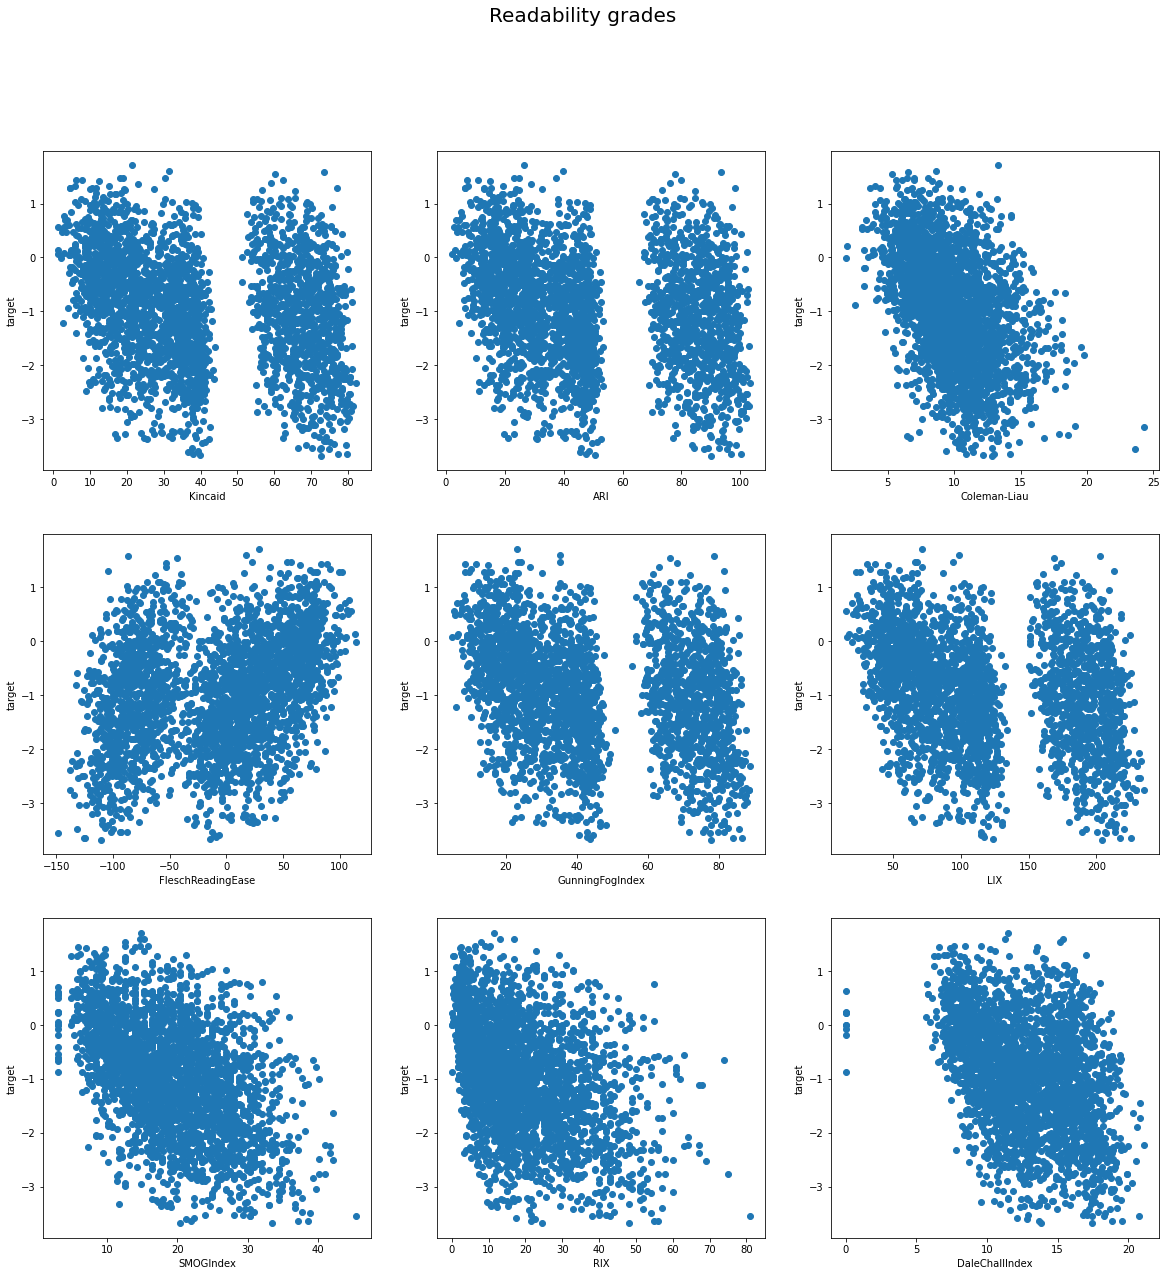

In [17]:
plot_scatter_grid(readability_grades, 
                  ["Kincaid", "ARI", "Coleman-Liau", 
                   "FleschReadingEase", "GunningFogIndex", "LIX", 
                   "SMOGIndex", "RIX", "DaleChallIndex"], 
                  "target", 3, 3, "Readability grades")

There is some correlation between readability grades and target. Some of the grades forms clusters.

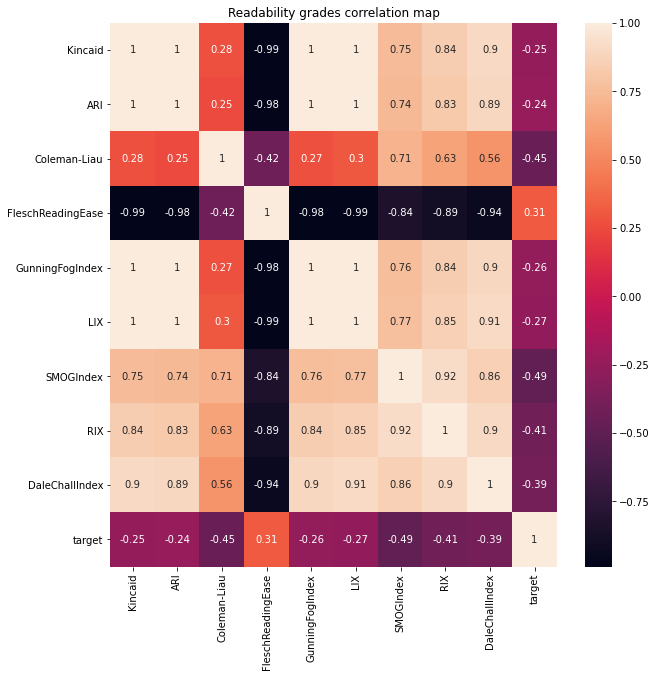

In [18]:
plt.figure(figsize=(10, 10))
sns.heatmap(readability_grades.corr(), annot=True)
plt.title("Readability grades correlation map")
plt.show()

There is high correlation between different readability grades, which is expected, because similar metrics are used for calculating them. *SMOGindex*, *Coleman-Liau* and *RIX* have highest correlation with the *target* variable 

### Syntactic properties

In [19]:
def get_syntactic_properties(excerpt):
    """ Calculate count of different syntactic properties for an excerpt"""
    return pd.Series(readability.getmeasures(excerpt)["sentence info"])

readability_syntactic = readability_data.excerpt.apply(get_syntactic_properties)

# all excerpts has 1 paragraph so drop the column
readability_syntactic = readability_syntactic.drop("paragraphs", axis=1)

readability_syntactic["target"] = readability_data.target

readability_syntactic.head()

,characters_per_word,syll_per_word,words_per_sentence,sentences_per_paragraph,type_token_ratio,characters,syllables,words,wordtypes,sentences,long_words,complex_words,complex_words_dc,target
id,,,,,,,,,,,,,,
c12129c31,4.407821,1.234637,29.833333,6.0,0.608939,789.0,221.0,179.0,109.0,6.0,32.0,17.0,42.0,-0.340259
85aa80a4c,4.145349,1.197674,28.666667,6.0,0.674419,713.0,206.0,172.0,116.0,6.0,26.0,12.0,28.0,-0.315372
b69ac6792,4.105882,1.211765,34.000000,5.0,0.711765,698.0,206.0,170.0,121.0,5.0,26.0,14.0,41.0,-0.580118
dd1000b26,4.365854,1.189024,82.000000,2.0,0.670732,716.0,195.0,164.0,110.0,2.0,25.0,4.0,33.0,-1.054013
37c1b32fb,3.734694,1.027211,147.000000,1.0,0.326531,549.0,151.0,147.0,48.0,1.0,6.0,4.0,7.0,0.247197


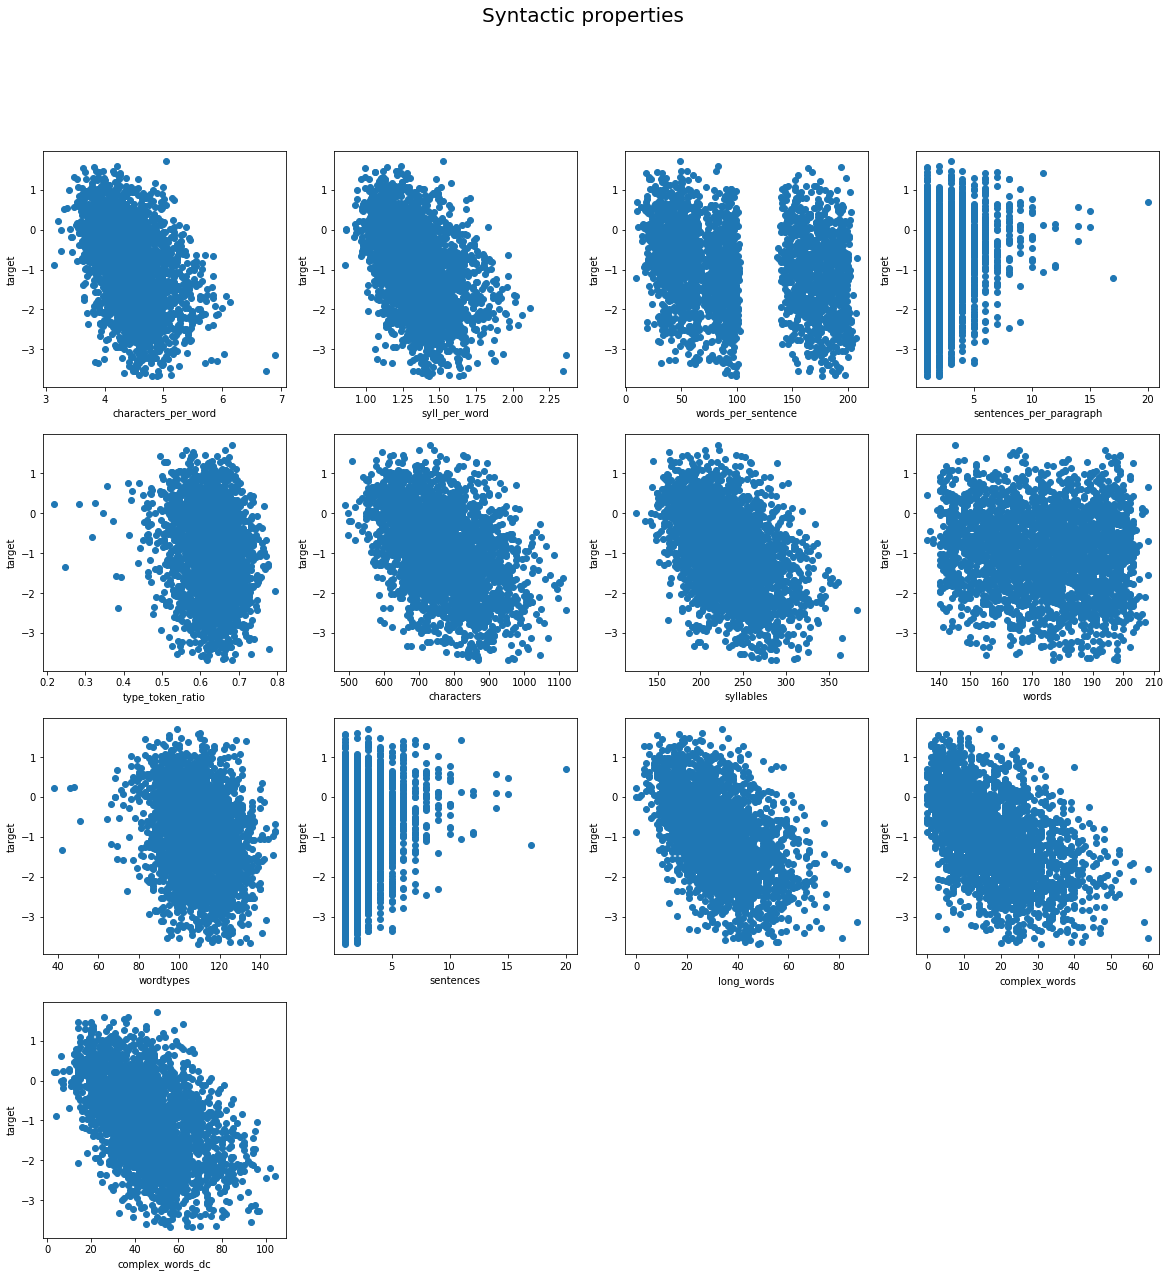

In [20]:
plot_scatter_grid(readability_syntactic, 
                  ["characters_per_word", "syll_per_word", "words_per_sentence", "sentences_per_paragraph",
                   "type_token_ratio", "characters", "syllables", "words", 
                   "wordtypes", "sentences", "long_words", "complex_words",
                   "complex_words_dc"],
                  "target", 4, 4, "Syntactic properties")

There is correlation between some of the properties and *target*.  

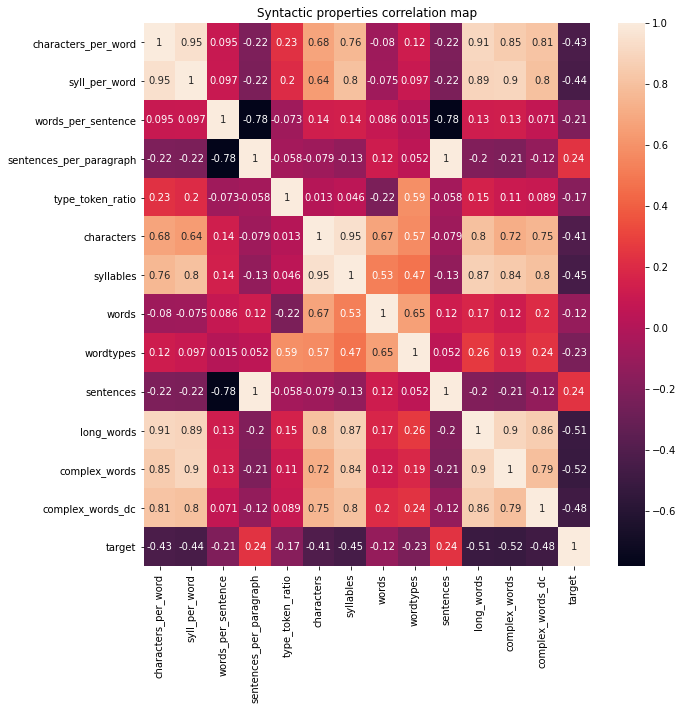

In [21]:
plt.figure(figsize=(10, 10))
sns.heatmap(readability_syntactic.corr(), annot=True)
plt.title("Syntactic properties correlation map")
plt.show()

Count of complex words and count of long words have highest correlation with the *target*. This seems logical because the more complex words the more difficult for reading is the exceprt.

### Part of the speech

In [22]:
def get_pos_tags(excerpt):
    pos_tags = nltk.pos_tag(nltk.word_tokenize(excerpt), tagset="universal")
    pos_tags_count = Counter([tag[1] for tag in pos_tags])
    return pd.Series(pos_tags_count)
    
readability_pos_tags = readability_data.excerpt.apply(get_pos_tags)
readability_pos_tags["target"] = readability_data.target

# rename columns
readability_pos_tags = readability_pos_tags.rename(columns={"." : "PUNC", "X" : "OTHER"})

readability_pos_tags.head()

,ADV,DET,ADJ,NOUN,VERB,PRT,PUNC,PRON,ADP,CONJ,NUM,OTHER,target
id,,,,,,,,,,,,,
c12129c31,6.0,34.0,13.0,48.0,35.0,3.0,25.0,4.0,21.0,11.0,4.0,NaN,-0.340259
85aa80a4c,16.0,11.0,13.0,32.0,43.0,7.0,51.0,29.0,13.0,7.0,NaN,1.0,-0.315372
b69ac6792,19.0,15.0,9.0,42.0,34.0,3.0,40.0,21.0,16.0,10.0,1.0,NaN,-0.580118
dd1000b26,2.0,20.0,16.0,52.0,19.0,2.0,30.0,12.0,23.0,15.0,3.0,NaN,-1.054013
37c1b32fb,2.0,32.0,13.0,51.0,10.0,2.0,28.0,7.0,17.0,10.0,3.0,NaN,0.247197


In [23]:
readability_pos_tags.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2834 entries, c12129c31 to 5b990ba77
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ADV     2831 non-null   float64
 1   DET     2834 non-null   float64
 2   ADJ     2834 non-null   float64
 3   NOUN    2834 non-null   float64
 4   VERB    2834 non-null   float64
 5   PRT     2814 non-null   float64
 6   PUNC    2834 non-null   float64
 7   PRON    2794 non-null   float64
 8   ADP     2834 non-null   float64
 9   CONJ    2829 non-null   float64
 10  NUM     1990 non-null   float64
 11  OTHER   275 non-null    float64
 12  target  2834 non-null   float64
dtypes: float64(13)
memory usage: 374.5+ KB


In [24]:
# Drop OTHER column as there are a lot of NULL VALUES
readability_pos_tags = readability_pos_tags.drop("OTHER", axis=1)

# Fill NULL values with 0
readability_pos_tags = readability_pos_tags.fillna(0)

readability_pos_tags.head()

,ADV,DET,ADJ,NOUN,VERB,PRT,PUNC,PRON,ADP,CONJ,NUM,target
id,,,,,,,,,,,,
c12129c31,6.0,34.0,13.0,48.0,35.0,3.0,25.0,4.0,21.0,11.0,4.0,-0.340259
85aa80a4c,16.0,11.0,13.0,32.0,43.0,7.0,51.0,29.0,13.0,7.0,0.0,-0.315372
b69ac6792,19.0,15.0,9.0,42.0,34.0,3.0,40.0,21.0,16.0,10.0,1.0,-0.580118
dd1000b26,2.0,20.0,16.0,52.0,19.0,2.0,30.0,12.0,23.0,15.0,3.0,-1.054013
37c1b32fb,2.0,32.0,13.0,51.0,10.0,2.0,28.0,7.0,17.0,10.0,3.0,0.247197


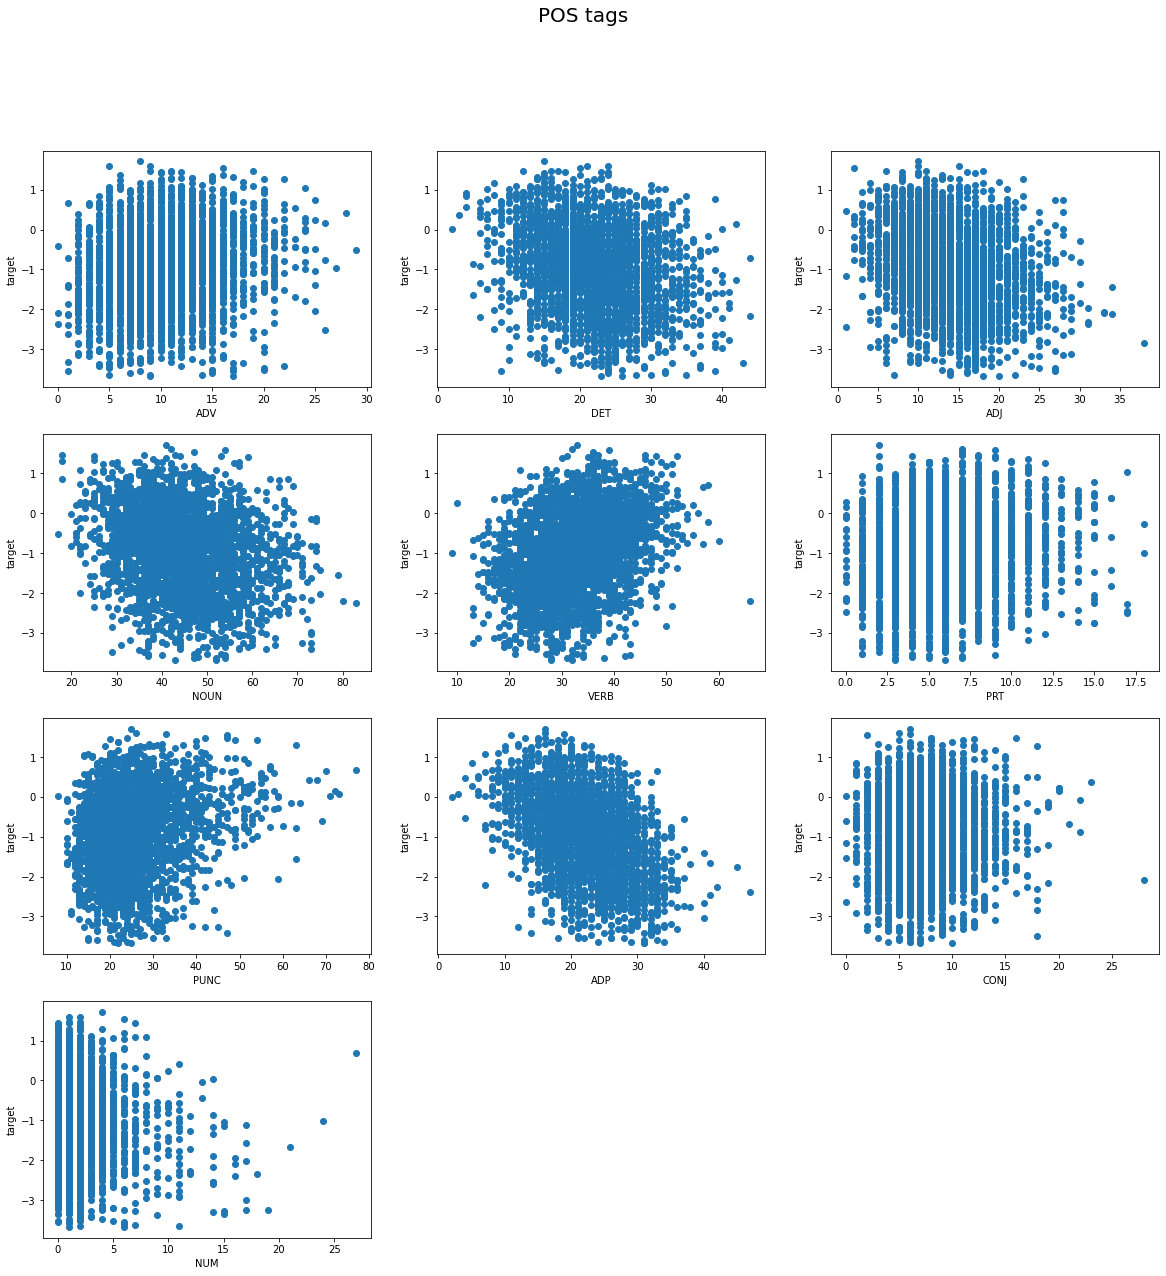

In [25]:
plot_scatter_grid(readability_pos_tags, 
                  ["ADV", "DET", "ADJ", "NOUN",
                   "VERB", "PRT", "PUNC", "ADP",
                  "CONJ", "NUM"], "target", 4, 3, "POS tags")

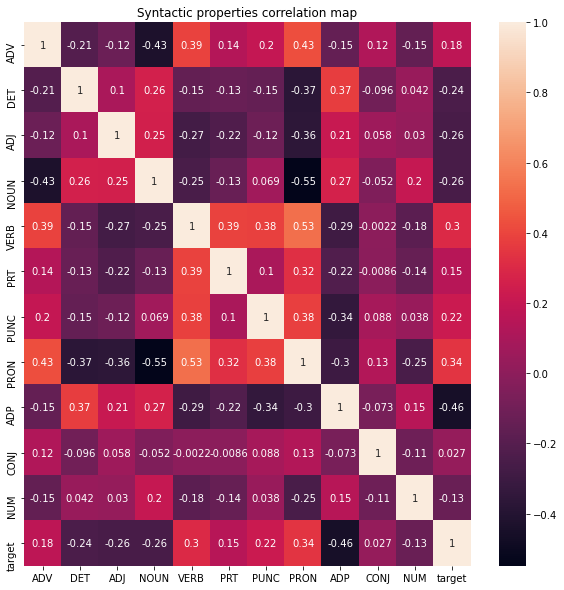

In [26]:
plt.figure(figsize=(10, 10))
sns.heatmap(readability_pos_tags.corr(), annot=True)
plt.title("Syntactic properties correlation map")
plt.show()

Adposition(subset of prepositions) count has highest correlation with *target*

### Word verctorization

Word vectorization is a methodology in NLP to map words or phrases from vocabulary to a corresponding vector of real numbers. [spacy](https://spacy.io/) module generates 300 features for each excerpt

In [33]:
def spacy_vectors(excerpt):
    """
    This function generates features using spacy en_core_wb_lg
    I learned about this from these resources:
    https://www.kaggle.com/ravishah1/readability-feature-engineering-non-nn-baseline
    https://www.kaggle.com/konradb/linear-baseline-with-cv
    https://www.kaggle.com/anaverageengineer/comlrp-baseline-for-complete-beginners
    """
    with nlp.disable_pipes():
        return pd.Series(nlp(excerpt).vector)

readability_spacy_features = readability_data.excerpt.apply(spacy_vectors)
readability_spacy_features.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
id,,,,,,,,,,,,,,,,,,,,,
c12129c31,0.054942,0.104693,-0.129839,-0.077362,0.066479,-0.007780,-0.010820,-0.054412,-0.069162,2.085747,...,-0.238603,0.031822,0.059434,-0.093304,-0.134071,0.053603,0.038264,-0.028437,-0.022459,0.068514
85aa80a4c,-0.014731,0.213879,-0.183907,-0.048958,0.112992,0.026316,0.028143,-0.137892,-0.094396,2.170374,...,-0.105756,0.051830,0.006578,-0.007093,0.065427,-0.029093,-0.000948,0.012834,0.015731,0.002224
b69ac6792,-0.006671,0.217069,-0.125178,-0.073087,0.106584,0.016715,0.011751,-0.115226,-0.071845,2.141033,...,-0.116192,0.020743,0.012045,-0.028818,0.044761,-0.033804,0.015294,-0.019791,0.020420,0.016437
dd1000b26,0.040802,0.123908,-0.106365,-0.109637,0.090377,0.020302,-0.004274,-0.007752,-0.103293,2.044155,...,-0.201305,0.014579,-0.002538,-0.046069,-0.155320,0.064200,0.079673,-0.035276,0.001438,0.066118
37c1b32fb,-0.018610,0.109863,-0.161603,-0.035534,0.143024,-0.053699,-0.026999,-0.152680,-0.012829,2.205194,...,-0.284280,0.039023,0.082985,-0.052379,-0.135277,0.122106,0.057177,-0.104051,-0.100320,0.024026


# Training models

In [28]:
readability_train = pd.concat([readability_grades, readability_syntactic, readability_pos_tags, readability_spacy_features], axis=1)
readability_train.head()

,Kincaid,ARI,Coleman-Liau,FleschReadingEase,GunningFogIndex,LIX,SMOGIndex,RIX,DaleChallIndex,target,...,290,291,292,293,294,295,296,297,298,299
id,,,,,,,,,,,,,,,,,,,,,
c12129c31,10.613715,14.247505,9.124776,72.103887,15.732216,47.710428,12.219544,5.333333,8.821150,-0.340259,...,-0.238603,0.031822,0.059434,-0.093304,-0.134071,0.053603,0.038264,-0.028437,-0.022459,0.068514
85aa80a4c,9.722558,12.427926,7.541115,76.415078,14.257364,43.782946,10.745967,4.333333,7.628832,-0.315372,...,-0.105756,0.051830,0.006578,-0.007093,0.065427,-0.029093,-0.000948,0.012834,0.015731,0.002224
b69ac6792,11.968824,14.908706,7.470958,69.809706,16.894118,49.294118,12.165151,5.200000,9.131076,-0.580118,...,-0.116192,0.020743,0.012045,-0.028818,0.044761,-0.033804,0.015294,-0.019791,0.020420,0.016437
dd1000b26,30.420488,40.133171,9.508945,23.013537,33.775610,97.243902,10.745967,12.500000,10.880956,-1.054013,...,-0.201305,0.014579,-0.002538,-0.046069,-0.155320,0.064200,0.079673,-0.035276,0.001438,0.066118
37c1b32fb,53.861088,69.660408,5.957366,-29.272041,59.888435,151.081633,13.954451,6.000000,0.000000,0.247197,...,-0.284280,0.039023,0.082985,-0.052379,-0.135277,0.122106,0.057177,-0.104051,-0.100320,0.024026


In [29]:
X = readability_train.loc[ : , readability_train.columns != 'target']
y = readability_train["target"]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [31]:
model = LinearRegression()
model.fit(X_train, y_train, )

y_predict = model.predict(X_test)

In [32]:
mean_squared_error(y_test, y_predict, squared=False)


0.6372875381712212